# Линейная регрессия

В этой записной книжке рассматривается решение на основе Python для первого упражнения по программированию из курса машинного обучения на Coursera. Пожалуйста, обратитесь к [тексту упражнения] (https://github.com/jdwittenauer/ipython-notebooks/blob/master/exercises/ML/ex1.pdf) для получения подробных описаний и уравнений.

В этом упражнении мы реализуем простую линейную регрессию с использованием градиентного спуска и применим ее к модельной задачи. Мы также расширим нашу реализацию на случай нескольких переменных и применим ее к немного более сложному примеру.

## С одной переменной

В первой части упражнения перед нами стоит задача реализовать линейную регрессию с одной переменной для прогнозирования прибыли фургона с едой. Предположим, вы являетесь генеральным директором франшизы и рассматриваете возможность открытия новой точки в разных городах. В сети уже есть грузовики в разных городах, и у вас есть данные о прибылях и населении в городах.

Начнем с импорта некоторых библиотек и изучения данных.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
%cd

C:\Users\k


In [22]:
import os
path = 'C:/Users/k/Desktop/srs/mach/bml/data/ex1data1.txt'
data = pd.read_csv(path, header=None, names=['Population', 'Profit'])
data.head()

,Population,Profit
0,6.1101,17.5920
1,5.5277,9.1302
2,8.5186,13.6620
3,7.0032,11.8540
4,5.8598,6.8233


In [4]:
data.describe()

,Population,Profit
count,97.000000,97.000000
mean,8.159800,5.839135
std,3.869884,5.510262
min,5.026900,-2.680700
25%,5.707700,1.986900
50%,6.589400,4.562300
75%,8.578100,7.046700
max,22.203000,24.147000


Let's plot it to get a better idea of what the data looks like.

<AxesSubplot:xlabel='Population', ylabel='Profit'>

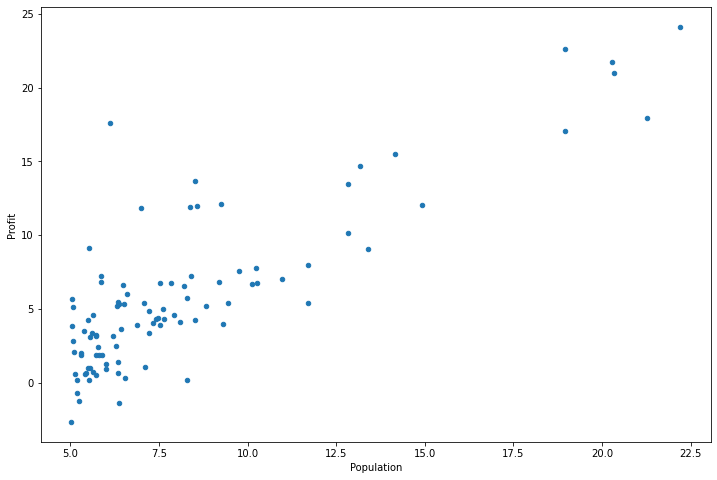

In [5]:
data.plot(kind='scatter', x='Population', y='Profit', figsize=(12,8))

In [23]:
x = np.array(data['Population'])
y = np.array(data['Profit'])

Now let's implement linear regression using gradient descent to minimize the cost function.  The equations implemented in the following code samples are detailed in "ex1.pdf" in the "exercises" folder.

First we'll create a function to compute the cost of a given solution (characterized by the parameters theta).

In [29]:
def MSE(x, y, thet):
    n = len(x)
    b = np.ones(n)
    A = np.stack([b,x]).T
    return ((A.dot(theta) - y)**2).sum()/(2*n)

In [30]:
x = np.array([2,3,5])
y = np.array([1,4,3])
theta = np.array([1,1])
MSE(x,y,theta)

2.1666666666666665

In [31]:
def computeCost(X, y, theta):
    inner = np.power(((X * theta.T) - y), 2)
    return np.sum(inner) / (2 * len(X))

Let's add a column of ones to the training set so we can use a vectorized solution to computing the cost and gradients.

In [7]:
data.insert(0, 'Ones', 1)

Now let's do some variable initialization.

In [8]:
# set X (training data) and y (target variable)
cols = data.shape[1]
X = data.iloc[:,0:cols-1]
y = data.iloc[:,cols-1:cols]

Let's take a look to make sure X (training set) and y (target variable) look correct.

In [9]:
X.head()

,Ones,Population
0,1,6.1101
1,1,5.5277
2,1,8.5186
3,1,7.0032
4,1,5.8598


In [10]:
y.head()

,Profit
0,17.5920
1,9.1302
2,13.6620
3,11.8540
4,6.8233


The cost function is expecting numpy matrices so we need to convert X and y before we can use them.  We also need to initialize theta.

In [11]:
X = np.matrix(X.values)
y = np.matrix(y.values)
theta = np.matrix(np.array([0,0]))

Here's what theta looks like.

In [12]:
theta

matrix([[0, 0]])

Let's take a quick look at the shape of our matrices.

In [13]:
X.shape, theta.shape, y.shape

((97, 2), (1, 2), (97, 1))

Now let's compute the cost for our initial solution (0 values for theta).

In [14]:
computeCost(X, y, theta)

32.072733877455676

So far so good.  Now we need to define a function to perform gradient descent on the parameters theta using the update rules defined in the text.

In [15]:
def gradientDescent(X, y, theta, alpha, iters):
    temp = np.matrix(np.zeros(theta.shape))
    parameters = int(theta.ravel().shape[1])
    cost = np.zeros(iters)
    
    for i in range(iters):
        error = (X * theta.T) - y
        
        for j in range(parameters):
            term = np.multiply(error, X[:,j])
            temp[0,j] = theta[0,j] - ((alpha / len(X)) * np.sum(term))
            
        theta = temp
        cost[i] = computeCost(X, y, theta)
        
    return theta, cost

Initialize some additional variables - the learning rate alpha, and the number of iterations to perform.

In [16]:
alpha = 0.01
iters = 1000

Now let's run the gradient descent algorithm to fit our parameters theta to the training set.

In [17]:
g, cost = gradientDescent(X, y, theta, alpha, iters)
g

matrix([[-3.24140214,  1.1272942 ]])

Finally we can compute the cost (error) of the trained model using our fitted parameters.

In [18]:
computeCost(X, y, g)

4.515955503078914

Now let's plot the linear model along with the data to visually see how well it fits.

Text(0.5, 1.0, 'Predicted Profit vs. Population Size')

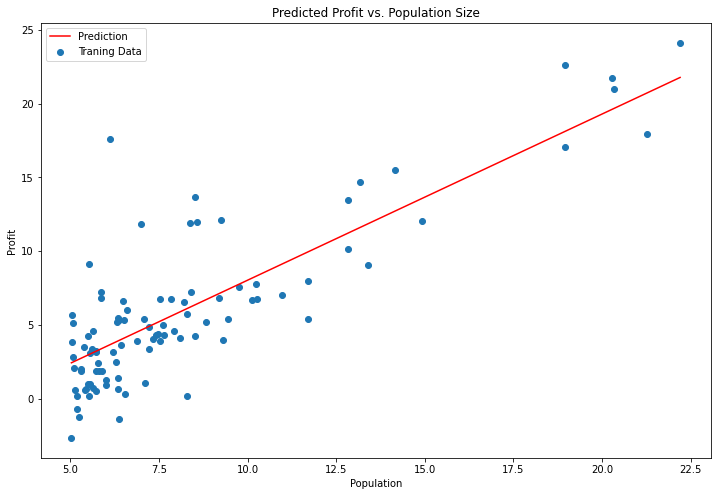

In [19]:
x = np.linspace(data.Population.min(), data.Population.max(), 100)
f = g[0, 0] + (g[0, 1] * x)

fig, ax = plt.subplots(figsize=(12,8))
ax.plot(x, f, 'r', label='Prediction')
ax.scatter(data.Population, data.Profit, label='Traning Data')
ax.legend(loc=2)
ax.set_xlabel('Population')
ax.set_ylabel('Profit')
ax.set_title('Predicted Profit vs. Population Size')

Looks pretty good!  Since the gradient decent function also outputs a vector with the cost at each training iteration, we can plot that as well.  Notice that the cost always decreases - this is an example of a convex optimization problem.

Text(0.5, 1.0, 'Error vs. Training Epoch')

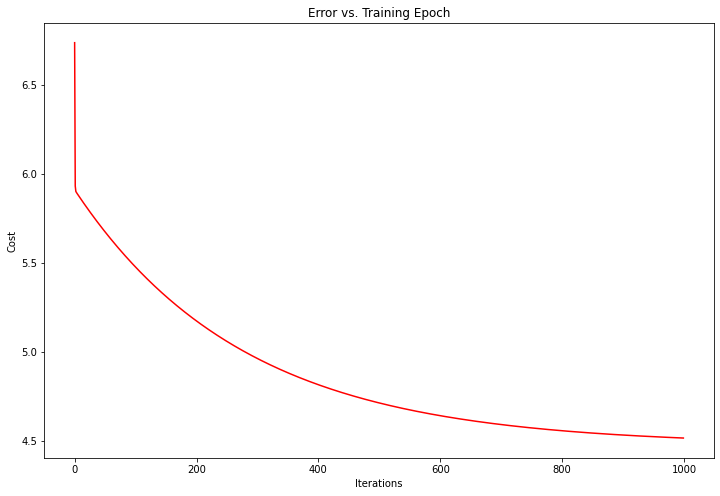

In [20]:
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(np.arange(iters), cost, 'r')
ax.set_xlabel('Iterations')
ax.set_ylabel('Cost')
ax.set_title('Error vs. Training Epoch')

## Linear regression with multiple variables

Exercise 1 also included a housing price data set with 2 variables (size of the house in square feet and number of bedrooms) and a target (price of the house).  Let's use the techniques we already applied to analyze that data set as well.

In [21]:
path = os.getcwd() + '\data\ex1data2.txt'
data2 = pd.read_csv(path, header=None, names=['Size', 'Bedrooms', 'Price'])
data2.head()

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\k\\data\\ex1data2.txt'

For this task we add another pre-processing step - normalizing the features.  This is very easy with pandas.

In [ ]:
data2 = (data2 - data2.mean()) / data2.std()
data2.head()

,Size,Bedrooms,Price
0,0.130010,-0.223675,0.475747
1,-0.504190,-0.223675,-0.084074
2,0.502476,-0.223675,0.228626
3,-0.735723,-1.537767,-0.867025
4,1.257476,1.090417,1.595389


Now let's repeat our pre-processing steps from part 1 and run the linear regression procedure on the new data set.

In [ ]:
# add ones column
data2.insert(0, 'Ones', 1)

# set X (training data) and y (target variable)
cols = data2.shape[1]
X2 = data2.iloc[:,0:cols-1]
y2 = data2.iloc[:,cols-1:cols]

# convert to matrices and initialize theta
X2 = np.matrix(X2.values)
y2 = np.matrix(y2.values)
theta2 = np.matrix(np.array([0,0,0]))

# perform linear regression on the data set
g2, cost2 = gradientDescent(X2, y2, theta2, alpha, iters)

# get the cost (error) of the model
computeCost(X2, y2, g2)

0.13070336960771897

We can take a quick look at the training progess for this one as well.

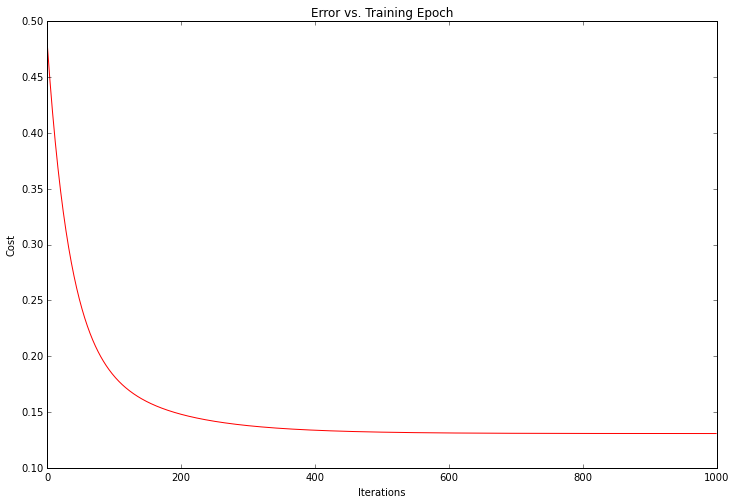

In [ ]:
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(np.arange(iters), cost2, 'r')
ax.set_xlabel('Iterations')
ax.set_ylabel('Cost')
ax.set_title('Error vs. Training Epoch')

Instead of implementing these algorithms from scratch, we could also use scikit-learn's linear regression function.  Let's apply scikit-learn's linear regressio algorithm to the data from part 1 and see what it comes up with.

In [ ]:
from sklearn import linear_model
model = linear_model.LinearRegression()
model.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, normalize=False)

Here's what the scikit-learn model's predictions look like.

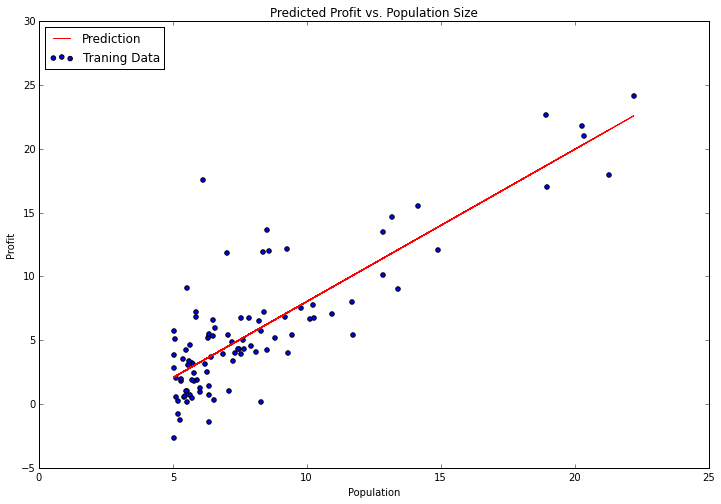

In [ ]:
x = np.array(X[:, 1].A1)
f = model.predict(X).flatten()

fig, ax = plt.subplots(figsize=(12,8))
ax.plot(x, f, 'r', label='Prediction')
ax.scatter(data.Population, data.Profit, label='Traning Data')
ax.legend(loc=2)
ax.set_xlabel('Population')
ax.set_ylabel('Profit')
ax.set_title('Predicted Profit vs. Population Size')

That's it!  Thanks for reading.  In Exercise 2 we'll take a look at logistic regression for classification problems.